<a href="https://colab.research.google.com/github/the-shawn/Auto-GPT/blob/master/Shared_Minds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome I hope you all enjoy yourselves in my little tiny notebook.


In [ ]:
#see what kind of GPU you get
#you might have to have to "change runtime type" under Runtime menu to a choice beyond CPU
#this is actually a command line command, the exclamation point at the beginning allows you to do that here
!nvidia-smi

Wed Sep 20 17:30:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#install hugging face libraries
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install diffusers[torch]
#install web libraries
!pip install fastapi nest-asyncio pyngrok uvicorn

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-afr7657e
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-afr7657e
  Resolved https://github.com/huggingface/transformers.git to commit e3a4bd2bee212a2d0fd9f03b27fe7bfc1debe42d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.34.0.dev0-py3-none-any.whl size=7700860 sha256=fa1aa8effea9d09937816d64911b7c3b2a45bc66c9f4d755439c9af31ab2ef9f
  Stored in directory: /tmp/pip-ephem-wheel-c

In [ ]:
#hf_ZyQkmMbfilFUcwkVcpchNbAZdmjJnCtN
#login to huggingface
#you have to have a huggingface login and find the API keys under "settings"
#this allows you to import the pretrained models from huggingface
from huggingface_hub import notebook_login
notebook_login()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

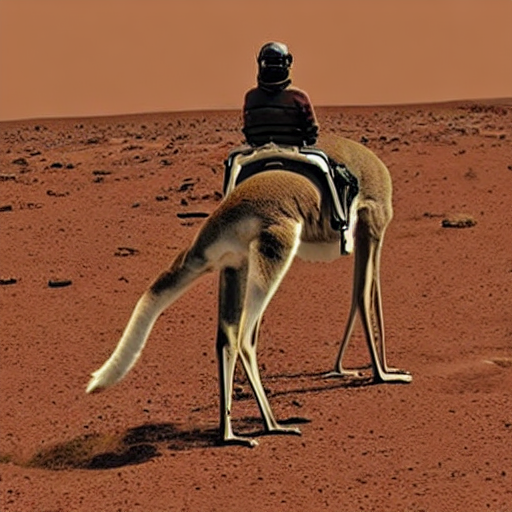

In [ ]:
#point your program at diffusers library
from diffusers import StableDiffusionPipeline
#point your program at a library for using GPUs
import torch

#download the model and instantiate a "pipeline" (only the first time you run it)
#a pipeline is a function that really simplifies all the details of the diffusion library
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

#this is just a quick test to make sure it works.  Really we want to call this from the web.
prompt = "a photo of an kangaroo riding a horse on mars"
image = pipe(prompt).images[0]
image

In [ ]:
# the function for you busines
from PIL import Image
from io import BytesIO
import base64
import skimage
import numpy

def encodeb64(image) -> str:

    # convert image to bytes
    with BytesIO() as output_bytes:
        PIL_image = Image.fromarray(skimage.img_as_ubyte(image))
        PIL_image.save(output_bytes, 'JPEG') # Note JPG is not a vaild type here
        bytes_data = output_bytes.getvalue()

    # encode bytes to base64 string
    base64_str = str(base64.b64encode(bytes_data), 'utf-8')
    return base64_str


In [ ]:
from fastapi import FastAPI
import nest_asyncio
import json
from pyngrok import ngrok
import uvicorn
from fastapi.encoders import jsonable_encoder
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
from fastapi import Request, FastAPI



#this is another way to package the incoming stuff so the documentation will see the structure.  We are not using
class DataIn(BaseModel):
    data: str

app = FastAPI()

origins = [
    "*",
    "http://localhost",
    "http://localhost:8080",
    "http://127.0.0.1:8000",
]

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"]
)


@app.get("/")
async def who():
  return {"Who": "Are You"}

@app.get("/hello/{name}")
async def hello(name):
  return {"Hello": name}


#@app.post.get("/helloBaseModel/")
#async def create_item(dataIn: DataIn):
#  return {"Hello": dataIn.prompt}


@app.post("/generateIt/")
async def get_body(request: Request):
  data = await request.json()
  promptFromClient = data["input"]["prompt"];
  width = data["input"]["width"]
  height = data["input"]["height"];
  images = pipe(promptFromClient,width=width,height=height).images
  b64Image = encodeb64(images[0])
  d = {
    "prompt": promptFromClient,
    "b64Image": b64Image,
  }
  #return jsonify(d)
  json_compatible_item_data = jsonable_encoder(d)
  return JSONResponse(content=json_compatible_item_data)


ngrok_tunnel = ngrok.connect(8000) # if you don't sign up for a domain you can do this.
#####OR
#PUT SIGN UP WITH NGROK AND GET A PERMANENT DOMAIN. PUT YOUR OWN STUFF IN HERE k5
#ngrok.set_auth_token("2VOny1Tv5CwO2FFdss0e81v0GpP_77N4RAWAxXrSgjiqnTb")
#ngrok_tunnel = ngrok.connect(8000, "http", domain="firm-honeybee-noticeably.ngrok-free.app")

print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()


uvicorn.run(app, port=8000)


Public URL: https://firm-honeybee-noticeably.ngrok-free.app


INFO:     Started server process [2144]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     216.165.95.158:0 - "OPTIONS /generateIt/ HTTP/1.1" 200 OK


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:     216.165.95.158:0 - "POST /generateIt/ HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2144]
